<a href="https://colab.research.google.com/github/teerasitk/01205415/blob/main/TechnicalTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install
1. yfinance for accessing yahoo finance data
2. tensortrade for trade simulation

In [1]:
!pip install yfinance
!pip install tensortrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.6/32.6 MB 27.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.7 MB/s eta 0:00:00
  Created wheel for tensortrade: filename=tensortrade-1.0.3-py3-none-any.whl size=134844 sha256=e0489364d2a5f287885e953e69e10d3ccf0edaac455ab097cc3e061359664739
  Stored in directory: /root/.cache/pip/wheels/7f/a7/75/792c00b8bcd136448db22cd2ca4b4bf0856a58a7dea881bcfc
Successfully built tensortrade


# Install Python Libraries

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensortrade.env.default as default
from tensortrade.feed.core import Stream, DataFeed, NameSpace
from tensortrade.oms.instruments import Instrument
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.env.default.renderers import PlotlyTradingChart, FileLogger

# Download AOT from 2015 to 2023

In [3]:
data_frame = yf.download("AOT.BK", "2015-01-01", "2023-12-31")
data_frame.head()

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-05,28.0,28.000000,27.200001,27.299999,24.920393,24970000
2015-01-06,26.9,27.400000,26.700001,27.200001,24.829111,24309000
2015-01-07,27.5,28.299999,27.500000,28.299999,25.833227,20682000
2015-01-08,28.9,29.000000,28.600000,28.900000,26.380932,23039000
2015-01-09,29.1,29.299999,28.900000,29.100000,26.563496,34221000


# Build Trade Environment

In [4]:
THB = Instrument(symbol="THB", precision=2, name="Thai Baht")
AOT = Instrument(symbol="AOT", precision=2, name="Airports of Thailand")
set_market = Exchange("set", service=execute_order,
                      options=ExchangeOptions(commission=0.0001))
# build exchange market
# commission is to 0.01%
buy_sell_prices = data_frame['Close'].tolist() # buy and sell prices are close prices
stream_prices = Stream.source(buy_sell_prices, dtype='float').rename("THB-AOT")
set_market = set_market(stream_prices)

# Build Features

In [5]:
close_prices = data_frame.Close
high_prices = data_frame.High
low_prices = data_frame.Low

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


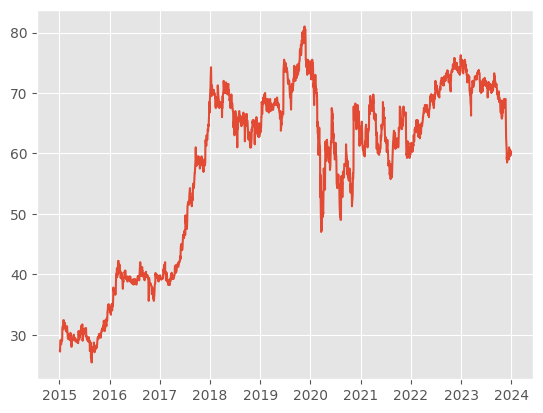

In [41]:
plt.plot(close_prices)

In [6]:
hist_len = 90 # look back 1 quarter
streams1 = [Stream.source(
    close_prices.shift(c)).rename(f"close_lag{c:02d}")
    for c in range(1, hist_len+1)] # 0-89: historical close prices
streams2 = [Stream.source(
    high_prices.shift(c)).rename(f"high_lag{c:02d}")
    for c in range(1, hist_len+1)] # 90-179: historical high prices
streams3 = [Stream.source(
    low_prices.shift(c)).rename(f"low_lag{c:02d}")
    for c in range(1, hist_len+1)] # 180-269: historical low prices
streams = streams1 + streams2 + streams3 #0-269
streams.append(Stream.source(high_prices, # today max
                         dtype="float").rename("max_of_day"))
streams.append(Stream.source(low_prices, # today min
                         dtype="float").rename("min_of_day"))


# Build Data feed

In [12]:
feed = DataFeed(streams)
# 0-89: historical close prices
# 90-179: historical high prices
# 180-269: historical low prices
# 270: max of the day
# 271: min of the day

In [ ]:
feed.next()

# Initialize Portfolios

In [9]:
cash = Wallet(set_market, 100_000 * THB) # initialize at 100k THB
asset = Wallet(set_market, 0 * AOT)
portfolio = Portfolio(THB, [cash,
                            asset])

# Build Trade Environment

In [14]:
env = default.create(
        portfolio=portfolio, # start with our portfolio
        action_scheme=default.actions.BSH(cash=cash, asset=asset), # all in and out
        # I made some changes here
        reward_scheme=default.rewards.SimpleProfit(), # simple profit (to be used later)
        feed=feed, # data feed for historical price
        window_size=1, # historical data that we need
        min_periods=hist_len # starting trading location
        )

# Test the envornment

In [15]:
obs = env.reset()
hist_close = obs[0][:90] # 0: yesterday
hist_high  = obs[0][90:180] # 90: yesterday
hist_low   = obs[0][180:270] # 180: yesterday
day_max = obs[0][270]
day_min = obs[0][271]
print("hist_close", hist_close)
print("hist_high", hist_high)
print("hist_low", hist_low)
print("max of the day", day_max)
print("min of the day", day_min)

hist_close [29.9 28.6 28.8 28.7 28.9 28.8 28.9 28.8 28.8 29.2 29.  29.  28.9 29.1
 29.2 29.5 29.1 29.1 29.2 29.4 29.2 30.  29.3 29.3 29.2 29.1 29.2 29.3
 29.1 28.  28.  29.3 29.5 30.1 29.8 30.3 29.7 29.9 29.8 29.1 29.4 29.5
 29.6 29.7 29.5 29.7 30.1 29.3 29.7 30.3 30.9 31.4 30.4 30.6 30.7 31.1
 30.7 31.3 30.7 31.2 31.2 31.6 31.9 31.5 31.4 32.  31.6 31.4 32.2 32.4
 32.4 30.9 31.1 31.3 31.4 31.  29.5 29.  29.  29.  28.9 28.9 28.4 29.
 29.1 29.1 28.9 28.3 27.2 27.3]
hist_high [29.9 29.2 29.1 29.2 28.9 29.  29.4 29.  29.2 29.2 29.  29.  29.1 29.2
 29.5 29.6 29.4 29.4 29.6 29.6 30.  30.1 29.3 29.5 29.6 29.5 29.4 29.7
 29.3 28.3 29.6 29.6 30.1 30.2 30.4 30.4 30.2 30.4 30.  29.5 29.6 29.9
 29.8 29.8 30.  30.2 30.2 29.7 30.2 30.8 31.4 31.4 30.9 31.1 31.2 31.3
 31.4 31.3 31.3 31.5 31.7 31.9 32.1 31.8 32.  32.2 32.  32.5 33.3 32.4
 32.4 31.2 31.7 31.7 32.  31.1 29.5 29.2 29.2 29.2 29.  29.2 29.3 29.3
 29.4 29.3 29.  28.3 27.4 28. ]
hist_low [28.7 28.6 28.4 28.5 28.5 28.4 28.9 28.7 28.8 28.6 29. 

# Moving Average Clossing
Buy if MA(n) > MA(m) for n = 20 and m = 50

In [16]:
done = False
obs = env.reset() # reset environment move to the first ate
actions = [0] # first action no hold
status = "No Position"
n = 20
m = 50
xt_m_1 = 0
action = 0 # all out
while not done: # loop until all data are exhausted
  # build trading rule here
  hist_close = obs[0][:90]
  hist_high  = obs[0][90:180]
  hist_low   = obs[0][180:270]
  day_max = obs[0][270]
  day_min = obs[0][271]
  MAn = np.mean(hist_close[:n])
  MAm = np.mean(hist_close[:m])
  xt = MAn - MAm
  if (xt > 0) and (xt_m_1 < 0): # buy
    action = 1 # All in
    status = "hold"
  elif (xt < 0) and (xt_m_1 >0) : # sell
    action = 0 # All out
    status = "No Position"
  else:
    pass
    #same action again
  actions.append(action) # keep all action
  obs, reward, done, info = env.step(action) # perform trading
  print(info, portfolio.balances)
  xt_m_1 = xt #update x(t-1)
portfolio.ledger.as_frame().head(7)

{'step': 1, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 2, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 3, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 4, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 5, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 6, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 7, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 8, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 9, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 10, 'net_worth': 100989.8974571228} [0.00 THB, 3333.00 AOT]
{'step': 11, 'net_worth': 102656.3974571228} [0.00 THB, 3333.00 AOT]
{'step': 12, 'net_worth': 102656.3974571228} [0.00 THB, 3333.00 AOT]
{'step': 13, 'net_worth': 103323.0} [0.00 THB, 3333.00 AOT]
{'step': 14, 'net_worth': 104989.5} [0.00 THB, 3333.00 AOT]
{'step': 15, 'net_worth': 104656.1987285614} [0.00 THB, 3333.00 AOT]
{'step': 16, 'net_worth': 103323.0} [0.00 THB, 3333.00 

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,5268855d-084b-42d3-b1e8-a8667da4813d,10,set:THB/free,set:THB/locked,LOCK (LOCK FOR ORDER),100000.00 THB,0.00 THB,100000.00 THB,100000.00 THB
1,5268855d-084b-42d3-b1e8-a8667da4813d,10,set:THB/locked,set,WITHDRAWAL (COMMISSION),10.00 THB,0.00 THB,99990.00 THB,99990.00 THB
2,5268855d-084b-42d3-b1e8-a8667da4813d,10,set:THB/locked,set,WITHDRAWAL (FILL ORDER),99990.00 THB,0.00 THB,0.00 THB,0.00 THB
3,5268855d-084b-42d3-b1e8-a8667da4813d,10,set,set:AOT/locked,DEPOSIT (TRADED 99990.00 THB set:THB/AOT @ 30.00),3333.00 AOT,0.00 AOT,3333.00 AOT,3333.00 AOT
4,5268855d-084b-42d3-b1e8-a8667da4813d,10,set:THB/locked,set:THB/free,UNLOCK THB (COMPLETED),0.00 THB,0.00 THB,0.00 THB,0.00 THB
5,5268855d-084b-42d3-b1e8-a8667da4813d,10,set:AOT/locked,set:AOT/free,UNLOCK AOT (COMPLETED),3333.00 AOT,3333.00 AOT,0.00 AOT,0.00 AOT
6,8b137709-f900-47ea-a094-9b7a03153de9,48,set:AOT/free,set:AOT/locked,LOCK (LOCK FOR ORDER),3333.00 AOT,0.00 AOT,3333.00 AOT,3333.00 AOT


## Determine the trade perfomance

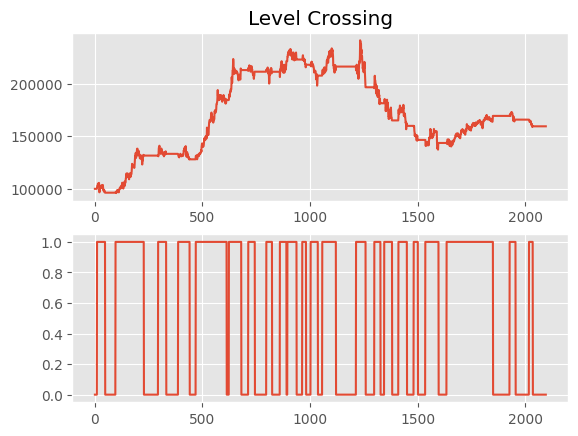

In [17]:
df = pd.DataFrame(portfolio.performance) # convert profolio performance to dataframe
df = df.T
plt.subplot(2,1,1)
plt.plot(df.net_worth) # plot networths
plt.title("Level Crossing")
plt.subplot(2,1,2)
plt.plot(actions) # plot actions

In [18]:
actions = np.asarray(actions) # change to numpy array
idx = np.where(actions[1:]-actions[:-1] > 0 )[0]
num_buys = len(idx)
idx = np.where(actions[1:]-actions[:-1] < 0 )[0]
num_sells = len(idx)
print(f"There are {num_buys} buys and  {num_sells} sells!!")

There are 22 buys and  22 sells!!


In [20]:
print(f"Level crossing Wealth {df.net_worth.iloc[-1]:,.2f}") # last net worth
print(f"Level crossing Gain {df.net_worth.iloc[-1]/100_000 -1:,.2f}") # last net worth
print(f"Level crossing Max Gain {df.net_worth.max()/100_000 -1:,.2f}") # last net worth
ret = df.net_worth.pct_change(1).dropna()
sharp_ration = ret.mean() / ret.std() #compute sharpe ratio
print(f"Sharpe ratio: {sharp_ration *np.sqrt(365):0.3f}")

Level crossing Wealth 159,556.85
Level crossing Gain 0.60
Level crossing Max Gain 1.42
Sharpe ratio: 0.511


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# High Low Envelop
Buy if today price is higher than HH(30) and sell if lower than LL(30)

In [21]:
cash = Wallet(set_market, 100_000 * THB) # initialize at 100k THB
asset = Wallet(set_market, 0 * AOT)
portfolio = Portfolio(THB, [cash,
                            asset])
env = default.create(
        portfolio=portfolio, # start with our portfolio
        action_scheme=default.actions.BSH(cash=cash, asset=asset), # all in and out
        # I made some changes here
        reward_scheme=default.rewards.SimpleProfit(), # simple profit (to be used later)
        feed=feed, # data feed for historical price
        window_size=1, # historical data that we need
        min_periods=hist_len # starting trading location
        )

In [26]:
done = False
obs = env.reset() # reset environment move to the first ate
actions = [0] # first action no hold
status = "No Position"
action = 0
n = 60
while not done: # loop until all data are exhausted
  # build trading rule here
  hist_close = obs[0][:90]
  hist_high  = obs[0][90:180]
  hist_low   = obs[0][180:270]
  day_max = obs[0][270]
  day_min = obs[0][271]
  HH = np.max(hist_high[:n]) # resistance
  LL = np.min(hist_low[:n]) # support
  if (day_max > HH) : # break resistance BUY
    action = 1
    status = "hold"
  elif (day_min < LL) : # break support SELL
    action = 0
    status = "No Position"
  else:
    pass
    # do the same
  actions.append(action) # keep all action
  obs, reward, done, info = env.step(action) # perform trading
  print(info, portfolio.balances)
portfolio.ledger.as_frame().head(7)

{'step': 1, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 2, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 3, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 4, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 5, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 6, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 7, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 8, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 9, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 10, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 11, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 12, 'net_worth': 99990.04152317047} [0.00 THB, 3246.43 AOT]
{'step': 13, 'net_worth': 100639.33} [0.00 THB, 3246.43 AOT]
{'step': 14, 'net_worth': 102262.545} [0.00 THB, 3246.43 AOT]
{'step': 15, 'net_worth': 101937.90076158523} [0.00 THB, 3246.43 AOT]
{'step': 16, 'net_worth': 100639.33} [0.00 THB, 3246.43 AOT]
{'st

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,6dcdadb8-7d7f-43d1-a25c-65ef6dffe018,12,set:THB/free,set:THB/locked,LOCK (LOCK FOR ORDER),100000.00 THB,0.00 THB,100000.00 THB,100000.00 THB
1,6dcdadb8-7d7f-43d1-a25c-65ef6dffe018,12,set:THB/locked,set,WITHDRAWAL (COMMISSION),10.00 THB,0.00 THB,99990.00 THB,99990.00 THB
2,6dcdadb8-7d7f-43d1-a25c-65ef6dffe018,12,set:THB/locked,set,WITHDRAWAL (FILL ORDER),99990.00 THB,0.00 THB,0.00 THB,0.00 THB
3,6dcdadb8-7d7f-43d1-a25c-65ef6dffe018,12,set,set:AOT/locked,DEPOSIT (TRADED 99990.00 THB set:THB/AOT @ 30.80),3246.43 AOT,0.00 AOT,3246.43 AOT,3246.43 AOT
4,6dcdadb8-7d7f-43d1-a25c-65ef6dffe018,12,set:THB/locked,set:THB/free,UNLOCK THB (COMPLETED),0.00 THB,0.00 THB,0.00 THB,0.00 THB
5,6dcdadb8-7d7f-43d1-a25c-65ef6dffe018,12,set:AOT/locked,set:AOT/free,UNLOCK AOT (COMPLETED),3246.43 AOT,3246.43 AOT,0.00 AOT,0.00 AOT
6,8dee8c1d-21b0-42c3-bbfb-3339e5cbc79d,57,set:AOT/free,set:AOT/locked,LOCK (LOCK FOR ORDER),3246.43 AOT,0.00 AOT,3246.43 AOT,3246.43 AOT


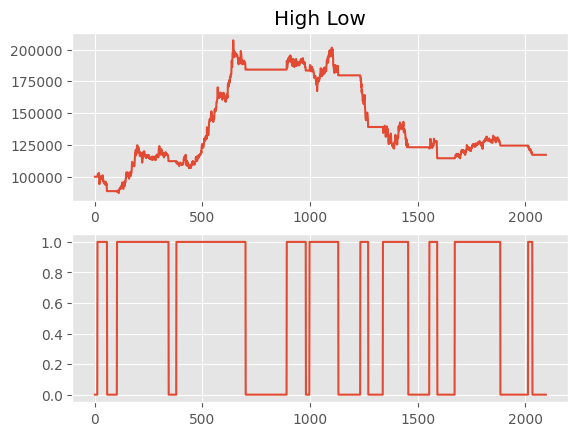

In [27]:
df2 = pd.DataFrame(portfolio.performance) # convert profolio performance to dataframe
df2 = df2.T
plt.subplot(2,1,1)
plt.plot(df2.net_worth) # plot networths
plt.title("High Low")
plt.subplot(2,1,2)
plt.plot(actions) # plot actions

In [28]:
print(f"High-Lower Envelop Wealth {df2.net_worth.iloc[-1]:,.2f}") # last net worth
print(f"High-Lower Envelop Gain {df2.net_worth.iloc[-1]/100_000 - 1:,.2f}") # last net worth
print(f"High-Lower Envelop Max Gain {df2.net_worth.max()/100_000 - 1:,.2f}") # last net worth
ret = df2.net_worth.pct_change(1).dropna()
sharp_ration = ret.mean() / ret.std() #compute sharpe ratio
print(f"Sharpe ratio: {sharp_ration *np.sqrt(365):0.3f}")

High-Lower Envelop Wealth 117,208.23
High-Lower Envelop Gain 0.17
High-Lower Envelop Max Gain 1.07
Sharpe ratio: 0.240


# Trend lines crossing
Let $T_t^u$ be upper trend line and $T^l_t$ be a lower trend line
Buy if $P_t > T_t^u$ and sell if $P_t < T_t^l$


In [29]:
cash = Wallet(set_market, 100_000 * THB) # initialize at 100k THB
asset = Wallet(set_market, 0 * AOT)
portfolio = Portfolio(THB, [cash,
                            asset])
env = default.create(
        portfolio=portfolio, # start with our portfolio
        action_scheme=default.actions.BSH(cash=cash, asset=asset), # all in and out
        # I made some changes here
        reward_scheme=default.rewards.SimpleProfit(), # simple profit (to be used later)
        feed=feed, # data feed for historical price
        window_size=1, # historical data that we need
        min_periods=hist_len # starting trading location
        )

0.013743261665494335 29.175091556460583


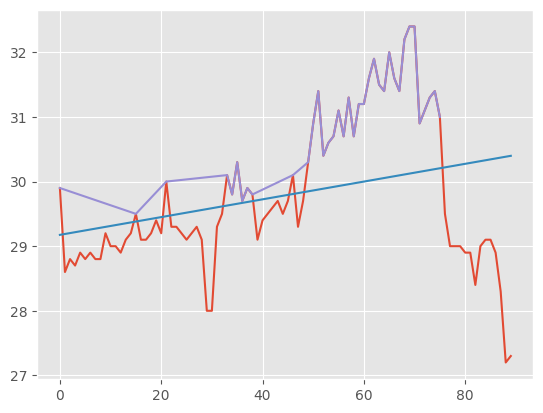

In [30]:
obs = env.reset() # reset environment move to the first ate
hist_close = obs[0][:90]
y = hist_close.copy()
x = np.arange(90)
A = np.array([x, np.ones(90)]).T
ab = np.linalg.lstsq(A, y, rcond=None) # EE MATH
a,b = ab[0]
print(a, b)
y_line = a * x + b
y_new = y[y >= y_line]
x_new = x[y >= y_line]
plt.plot(x, hist_close)
plt.plot(x, a *x +b)
plt.plot(x_new, y_new)

In [31]:
def findUpperTrendLine(hist_prices: np.array) -> tuple:
  max_iter = 10
  min_points = 5
  current_iter = 0
  current_points = len(hist_prices)
  n = current_points
  x = np.arange(n)
  y = hist_prices.copy()
  while (current_iter < max_iter) and (current_points > min_points):
    current_iter += 1
    # Find a, b
    A = np.array([x, np.ones(len(x))]).T
    ab = np.linalg.lstsq(A, y, rcond=None)
    a,b = ab[0]
    y_line = a * x + b
    x = x[y >= y_line]
    y = y[y >= y_line]
    current_points = len(x)
  return a, b


In [32]:
def findLowerTrendLine(hist_prices: np.array) -> tuple:
  max_iter = 10
  min_points = 5
  current_iter = 0
  current_points = len(hist_prices)
  n = current_points
  x = np.arange(n)
  y = hist_prices.copy()
  while (current_iter < max_iter) and (current_points > min_points):
    current_iter += 1
    # Find a, b
    A = np.array([x, np.ones(len(x))]).T
    ab = np.linalg.lstsq(A, y, rcond=None)
    a,b = ab[0]
    y_line = a * x + b
    x = x[y <= y_line]
    y = y[y <= y_line]
    current_points = len(x)
  return a, b

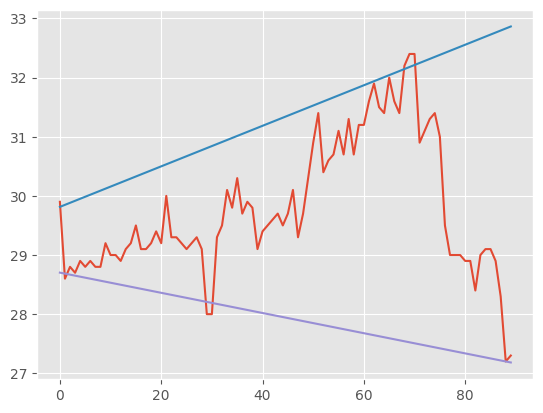

In [33]:
a, b = findUpperTrendLine(hist_close)
x = np.arange(len(hist_close))
plt.plot(x,hist_close)
plt.plot(x, a * x +b)
a, b = findLowerTrendLine(hist_close)
plt.plot(x, a * x +b)

In [42]:
done = False
obs = env.reset() # reset environment move to the first ate
actions = [0] # first action no hold
status = "No Position"
action = 0
n = 90
while not done: # loop until all data are exhausted
  # build trading rule here
  hist_close = obs[0][:90]
  hist_high  = obs[0][90:180]
  hist_low   = obs[0][180:270]
  day_max = obs[0][270]
  day_min = obs[0][271]
  ah,bh = findUpperTrendLine(hist_close[:n])
  al,bl = findLowerTrendLine(hist_close[:n])
  phigh = ah * (-1) + bh #upper trend line x = n
  plow = al * (-1) + bl #lower trend line
  if (day_max > phigh): # break upper trend line
    action = 1 # buy all
    status = "hold"
  elif (day_min < plow): # break lower trend line
    action = 0 # sell all
    status = "No Position"
  else:
    pass
  actions.append(action) # keep all action
  obs, reward, done, info = env.step(action) # perform trading
  print(info, portfolio.balances)
portfolio.ledger.as_frame().head(7)

{'step': 1, 'net_worth': 101651.05926721572} [0.00 THB, 3321.93 AOT]
{'step': 2, 'net_worth': 100654.47646556854} [0.00 THB, 3321.93 AOT]
{'step': 3, 'net_worth': 97664.74073278427} [0.00 THB, 3321.93 AOT]
{'step': 4, 'net_worth': 97000.35853443145} [0.00 THB, 3321.93 AOT]
{'step': 5, 'net_worth': 98993.51146556853} [0.00 THB, 3321.93 AOT]
{'step': 6, 'net_worth': 98329.12926721573} [0.00 THB, 3321.93 AOT]
{'step': 7, 'net_worth': 98993.51146556853} [0.00 THB, 3321.93 AOT]
{'step': 8, 'net_worth': 100322.28853443146} [0.00 THB, 3321.93 AOT]
{'step': 9, 'net_worth': 99657.9} [0.00 THB, 3321.93 AOT]
{'step': 10, 'net_worth': 100654.47646556854} [0.00 THB, 3321.93 AOT]
{'step': 11, 'net_worth': 102315.44146556854} [0.00 THB, 3321.93 AOT]
{'step': 12, 'net_worth': 102315.44146556854} [0.00 THB, 3321.93 AOT]
{'step': 13, 'net_worth': 102979.83} [0.00 THB, 3321.93 AOT]
{'step': 14, 'net_worth': 104640.795} [0.00 THB, 3321.93 AOT]
{'step': 15, 'net_worth': 104308.60073278427} [0.00 THB, 3321.

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,5c9c354a-db27-431c-b24e-e3d5e6b4cb25,1,set:THB/free,set:THB/locked,LOCK (LOCK FOR ORDER),100000.00 THB,0.00 THB,100000.00 THB,100000.00 THB
1,5c9c354a-db27-431c-b24e-e3d5e6b4cb25,1,set:THB/locked,set,WITHDRAWAL (COMMISSION),10.00 THB,0.00 THB,99990.00 THB,99990.00 THB
2,5c9c354a-db27-431c-b24e-e3d5e6b4cb25,1,set:THB/locked,set,WITHDRAWAL (FILL ORDER),99990.00 THB,0.00 THB,0.00 THB,0.00 THB
3,5c9c354a-db27-431c-b24e-e3d5e6b4cb25,1,set,set:AOT/locked,DEPOSIT (TRADED 99990.00 THB set:THB/AOT @ 30.10),3321.93 AOT,0.00 AOT,3321.93 AOT,3321.93 AOT
4,5c9c354a-db27-431c-b24e-e3d5e6b4cb25,1,set:THB/locked,set:THB/free,UNLOCK THB (COMPLETED),0.00 THB,0.00 THB,0.00 THB,0.00 THB
5,5c9c354a-db27-431c-b24e-e3d5e6b4cb25,1,set:AOT/locked,set:AOT/free,UNLOCK AOT (COMPLETED),3321.93 AOT,3321.93 AOT,0.00 AOT,0.00 AOT
6,e454b225-833f-4074-97f0-5633a08b87a7,23,set:AOT/free,set:AOT/locked,LOCK (LOCK FOR ORDER),3321.93 AOT,0.00 AOT,3321.93 AOT,3321.93 AOT


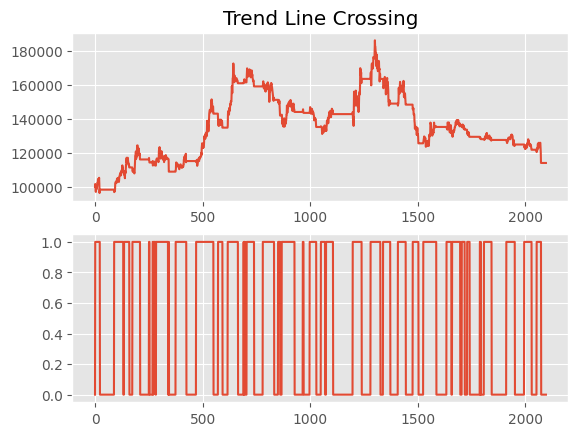

In [43]:
df3 = pd.DataFrame(portfolio.performance) # convert profolio performance to dataframe
df3 = df3.T
plt.subplot(2,1,1)
plt.plot(df3.net_worth) # plot networths
plt.title("Trend Line Crossing")
plt.subplot(2,1,2)
plt.plot(actions) # plot actions

In [44]:
print(f"Trend Line Crossing Wealth {df3.net_worth.iloc[-1]:,.2f}") # last net worth
print(f"Trend Line Crossing Gain {df3.net_worth.iloc[-1]/100_000 - 1:,.2f}") # last net worth
print(f"Trend Line Crossing Max Gain {df3.net_worth.max()/100_000 - 1:,.2f}") # last net worth
ret = df3.net_worth.pct_change(1).dropna()
sharp_ration = ret.mean() / ret.std() #compute sharpe ratio
print(f"Sharpe ratio: {sharp_ration *np.sqrt(365):0.3f}")

Trend Line Crossing Wealth 114,028.12
Trend Line Crossing Gain 0.14
Trend Line Crossing Max Gain 0.86
Sharpe ratio: 0.215
